In [ ]:
!pip install datasets>=2.6.1
!pip install git+https://github.com/huggingface/transformers
!pip install librosa
!pip install evaluate>=0.30
!pip install jiwer
!pip install gradio
!pip install -q bitsandbytes datasets accelerate loralib
!pip install transformers==4.45.2
!pip install peft
!pip install matplotlib
!pip install tensorboard

In [1]:
# -------------------Set model properties-----------------------------------
model_name_or_path = "openai/whisper-small"
language = "bengali"
task = "transcribe"

In [2]:
#---------------------------Load Dataset--------------------------------------
from datasets import load_dataset, DatasetDict
# Load the full dataset
full_train = load_dataset("imonghose/bengali-asr-data", split="train")
# full_test = load_dataset(
#     "imonghose/bengali-asr-data",
#     data_files={"test": ["data/test-00000-of-00002.parquet", "data/test-00001-of-00002.parquet"]},
#     split="test"
# )
full_test = load_dataset("imonghose/bengali-asr-data", split="test")



# Get dataset sizes
train_size = len(full_train)
test_size = len(full_test)
# Compute the original train-test ratio
original_ratio = test_size / train_size
# Compute the new test size corresponding to 60% train size
new_train_size = int(0.05 * train_size)
new_test_size = int(0.2 * test_size)
train_sample = full_train.shuffle(seed=42).select(range(new_train_size))
test_sample = full_test.shuffle(seed=42).select(range(new_test_size))
# Create a new dataset dictionary
bangla_dataset = DatasetDict({
    "train": train_sample,
    "test": test_sample
})

c:\IMON\Masters\DKE Course\Semester 3\HCNLP\FINE_TUNE_WHISPER\whisper-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.


In [3]:
#-----------Check dataset shape----------
bangla_dataset.shape

{'train': (7978, 3), 'test': (2042, 3)}

In [4]:
#-----------Check dataset structure----------
bangla_dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence', 'length'],
        num_rows: 7978
    })
    test: Dataset({
        features: ['audio', 'sentence', 'length'],
        num_rows: 2042
    })
})

In [ ]:
#------------------------CODE TO DELETE Loaded dataset from cache-------------------------

# !ls -lh ~/.cache/huggingface/datasets

# !rm -rf ~/.cache/huggingface/datasets/rootflo___bengali-asr-data
# !rm -rf ~/.cache/huggingface/datasets/_root_.cache_huggingface_datasets_rootflo___bengali-asr-data_default_0.0.0_bbea669d7678c71e778d0c20f4fbed55ea9bc0f7.lock

# !rm -rf ~/.cache/huggingface/
# !rm -rf ~/.cache/datasets/
# !rm -rf ~/.cache/torch/
# !rm -rf ~/.cache/

ls: cannot access '/root/.cache/huggingface/datasets': No such file or directory


In [ ]:
#--------------Install correct version of Transformers library-----------------------
!pip install transformers==4.45.2
# !pip install --upgrade transformers


In [5]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained(model_name_or_path,language=language,task=task)

In [6]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained(model_name_or_path,language=language,task=task)

In [7]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(model_name_or_path, language=language, task=task)

In [8]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

In [9]:
#-------------------Check sampling rate before downsampling-----------------
print(bangla_dataset["train"][16])

{'audio': {'path': None, 'array': array([-0.00280762, -0.00262451, -0.00244141, ..., -0.00317383,
        0.00238037,  0.00650024]), 'sampling_rate': 16000}, 'sentence': 'পদ্মা সেতু প্রকল্প পরিচালক', 'length': 2.5}


In [10]:
#--------------------Downsample to 16 KHz--------------------------
from datasets import Audio

bangla_dataset = bangla_dataset.cast_column("audio", Audio(sampling_rate=16000))

In [11]:
#-------------------Check sampling rate after downsampling-----------------
print(bangla_dataset["train"][0])

{'audio': {'path': None, 'array': array([ 0.00189209,  0.0015564 ,  0.00189209, ...,  0.00039673,
        0.00033569, -0.00079346]), 'sampling_rate': 16000}, 'sentence': 'আবদুর রহমান বয়াতি', 'length': 3.2}


In [11]:
#------------------Custom preprocessing function for dataset-----------------------------
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch


In [12]:
#-------------------------Execute preprocessing---------------------------
bangla_dataset = bangla_dataset.map(prepare_dataset, remove_columns=bangla_dataset.column_names["train"], num_proc=1)
# bangla_dataset = bangla_dataset.map(
#     prepare_dataset,
#     remove_columns=bangla_dataset.column_names["train"],
#     batched=True,  # Process in batches
#     batch_size=10,  # Reduce batch size to lower memory usage
#     num_proc=1
# )


In [13]:
#--------------check dataset structure after preprocessing------------
bangla_dataset["test"]

Dataset({
    features: ['input_features', 'labels'],
    num_rows: 2042
})

In [14]:
#--------------check dataset structure after preprocessing------------
bangla_dataset["train"]

Dataset({
    features: ['input_features', 'labels'],
    num_rows: 7978
})

In [17]:
#-----------------------Check path where hugging face datasets are stored in cache--------------------
# from datasets import config
# config.HF_DATASETS_CACHE

In [15]:
#-------------------Check first sentence by decoding-----------------------
first_label_ids = bangla_dataset["train"][0]["labels"]  # Get the first label (token IDs)
first_sentence = tokenizer.decode(first_label_ids)  # Decode to text

print(first_sentence)


<|startoftranscript|><|bn|><|transcribe|><|notimestamps|>আবদুর রহমান বয়াতি<|endoftext|>


In [ ]:
# -----------------------------Visualization of sentence token sizes vs frequency------------------------
import matplotlib.pyplot as plt

list_of_transcription_lengths = []

# Extract labels from dataset and compute their lengths
for data in bangla_dataset["train"]:
    list_of_transcription_lengths.append(len(data["labels"]))

# Plot the histogram
plt.hist(list_of_transcription_lengths, bins=50)  # Adjust bins for better visualization
plt.xlabel("Sentence Length (Number of Tokens)")
plt.ylabel("Number of Transcripts")
plt.title("Distribution of Transcription Lengths")
plt.show()


In [16]:
#------------------------------Check true vs prediction on few sentences before fine-tuning------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["train"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["train"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = model.generate(input_feature, language='bengali', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


-------7------
True : চলতে পারিনা 
Pred :  चोलते परिना

 
-------8------
True : নিজের স্বজনের জন্য 
Pred :  निजर साजने जन्नो

 
-------9------
True : সে যুদ্ধকেই 
Pred :  शेजुद्द के इए

 


In [18]:
#-------------------------------------Define Data Collator to introduce padding-------------------------------
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [19]:
#----------------------------Load Data Collator-----------------------------
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [20]:
#------------------------Define evaluation metric wer------------------------
import evaluate
wer = evaluate.load("wer")

In [20]:
#===================================Custom Evaluation Function for WER Metric with Periodic Plotting===================================
import torch
import pickle
from tqdm import tqdm
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

wer = evaluate.load("wer")
SAVE_PATH = "evaluation_progress.pkl"

def save_progress(progress):
    with open(SAVE_PATH, "wb") as f:
        pickle.dump(progress, f)

def load_progress():
    try:
        with open(SAVE_PATH, "rb") as f:
            return pickle.load(f)
    except FileNotFoundError:
        return {"predictions": [], "references": [], "processed_batches": 0, "wer_history": [], "batch_history": []}

def plot_wer(batch_history, wer_history):
    clear_output(wait=True)
    plt.figure(figsize=(10, 4))
    plt.plot(batch_history, wer_history, marker='o', label='WER (%)')
    plt.xlabel('Batches Processed')
    plt.ylabel('WER')
    plt.title('Running WER Evaluation')
    plt.grid(True)
    plt.legend()
    # Set ticks at intervals of 25 starting from 0 to max batch
    max_batch = max(batch_history) if batch_history else 0
    plt.xticks(np.arange(0, max_batch + 1, 25))
    display(plt.gcf())
    plt.close()

def evaluation(model, resume=False):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    test_dataset = bangla_dataset["test"]
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=False,
        collate_fn=data_collator
    )

    model.eval()

    # Load previous progress if resuming
    progress = load_progress() if resume else {"predictions": [], "references": [], "processed_batches": 0, "wer_history": [], "batch_history": []}
    predictions, references = progress["predictions"], progress["references"]
    start_batch = progress["processed_batches"]
    wer_history = progress.get("wer_history", [])
    batch_history = progress.get("batch_history", [])

    for batch_idx, batch in enumerate(tqdm(test_dataloader, total=len(test_dataloader))):
        if batch_idx < start_batch:
            continue  # Skip already processed batches

        input_features = batch["input_features"].to(device)
        labels = batch["labels"]

        with torch.no_grad():
            generated_tokens = model.generate(input_features=input_features, language='bengali', task='transcribe')

        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels.tolist(), skip_special_tokens=True)

        predictions.extend(decoded_preds)
        references.extend(decoded_labels)

        is_final = (batch_idx == len(test_dataloader) - 1)
        if (batch_idx + 1) % 25 == 0 or is_final:
            current_wer = wer.compute(predictions=predictions, references=references) * 100
            wer_history.append(current_wer)
            batch_history.append(batch_idx + 1)
            plot_wer(batch_history, wer_history)
            save_progress({
                "predictions": predictions,
                "references": references,
                "processed_batches": batch_idx + 1,
                "wer_history": wer_history,
                "batch_history": batch_history
            })

    return wer_history[-1] if wer_history else None


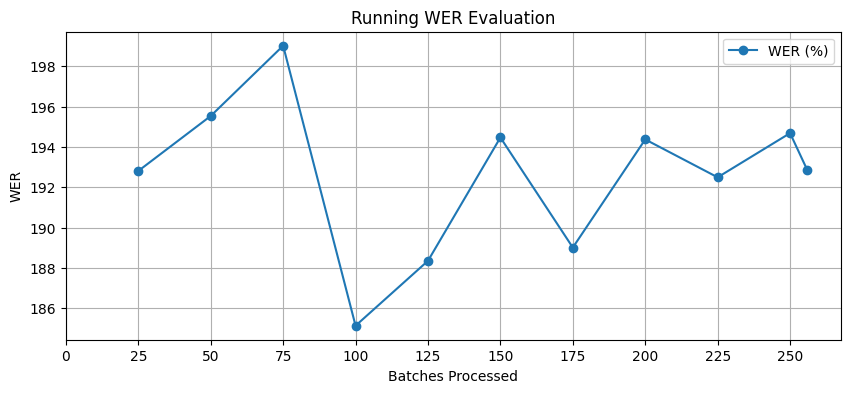

100%|██████████| 256/256 [1:17:50<00:00, 18.25s/it]


192.83608932407455

In [17]:
# Evaluate WER before the training
torch.cuda.empty_cache()
evaluation(model)

In [ ]:
# import torch
# import torch.nn as nn
# from transformers import WhisperForConditionalGeneration


# class Adapter(nn.Module):
#     def __init__(self, hidden_size, adapter_dim=64):
#         super().__init__()
#         self.down_proj = nn.Linear(hidden_size, adapter_dim)
#         self.activation = nn.ReLU()
#         self.up_proj = nn.Linear(adapter_dim, hidden_size)

#     def forward(self, x):
#         return x + self.up_proj(self.activation(self.down_proj(x)))


# class WhisperWithAdapters(WhisperForConditionalGeneration):
#     def __init__(self, config, adapter_dim=64):
#         super().__init__(config)
#         self.adapter_dim = adapter_dim
#         self._add_adapters()

#     def _add_adapters(self):
#         for layer in self.model.encoder.layers:
#             hidden_size = layer.self_attn.embed_dim
#             layer.adapter_attn = Adapter(hidden_size, self.adapter_dim)
#             layer.adapter_mlp = Adapter(hidden_size, self.adapter_dim)

#             orig_forward = layer.forward

#             def patched_forward(self, hidden_states, attention_mask=None, output_attentions=False, **kwargs):
#                 outputs = orig_forward(hidden_states, attention_mask=attention_mask, output_attentions=output_attentions, **kwargs)
#                 hidden_states = outputs[0]
#                 hidden_states = self.adapter_attn(hidden_states)
#                 hidden_states = self.adapter_mlp(hidden_states)
#                 return (hidden_states,) + outputs[1:]

#             layer.forward = patched_forward.__get__(layer, type(layer))
            
#     def freeze_all_but_adapters(self):
#         for param in self.parameters():
#             param.requires_grad = False

#         for layer in self.model.encoder.layers:
#             for name, module in layer.named_modules():
#                 if 'adapter' in name:
#                     for param in module.parameters():
#                         param.requires_grad = True

#     def save_pretrained(self, save_directory, **kwargs):
#         # Save config so adapter_dim is preserved
#         self.config.adapter_dim = self.adapter_dim
#         super().save_pretrained(save_directory, **kwargs)

#     @classmethod
#     def from_pretrained(cls, pretrained_model_name_or_path, *model_args, config=None, **kwargs):
#         from transformers import AutoConfig
#         if config is None:
#             config = AutoConfig.from_pretrained(pretrained_model_name_or_path)
#         adapter_dim = getattr(config, "adapter_dim", 64)
#         model = super().from_pretrained(
#             pretrained_model_name_or_path,
#             *model_args,
#             config=config,
#             **kwargs
#         )
#         # Re-wrap in our custom class
#         model.__class__ = cls
#         model.adapter_dim = adapter_dim
#         model._add_adapters()
#         return model


In [30]:
import torch
import torch.nn as nn
from transformers import WhisperForConditionalGeneration


class Adapter(nn.Module):
    def __init__(self, hidden_size, adapter_dim=64):
        super().__init__()
        self.down_proj = nn.Linear(hidden_size, adapter_dim)
        self.activation = nn.GELU()
        self.up_proj = nn.Linear(adapter_dim, hidden_size)

        # Xavier initialization
        nn.init.xavier_uniform_(self.down_proj.weight)
        nn.init.zeros_(self.down_proj.bias)
        nn.init.xavier_uniform_(self.up_proj.weight)
        nn.init.zeros_(self.up_proj.bias)

    def forward(self, x):
        return x + self.up_proj(self.activation(self.down_proj(x)))


class WhisperWithAdapters(WhisperForConditionalGeneration):
    def __init__(self, config, adapter_dim=64):
        super().__init__(config)
        self.adapter_dim = adapter_dim
        self._add_adapters()

    def _add_adapters(self):
        # Encoder adapters
        for layer in self.model.encoder.layers:
            hidden_size = layer.self_attn.embed_dim
            layer.adapter = Adapter(hidden_size, self.adapter_dim)

            original_forward = layer.forward

            def patched_forward(self, hidden_states, attention_mask=None, output_attentions=False, **kwargs):
                outputs = original_forward(
                    hidden_states,
                    attention_mask=attention_mask,
                    output_attentions=output_attentions,
                    **kwargs
                )
                hidden_states = outputs[0]
                hidden_states = self.adapter(hidden_states)
                return (hidden_states,) + outputs[1:]

            layer.forward = patched_forward.__get__(layer, type(layer))

        # Decoder adapters
        for layer in self.model.decoder.layers:
            hidden_size = layer.self_attn.embed_dim
            layer.adapter = Adapter(hidden_size, self.adapter_dim)

            original_forward = layer.forward

            def patched_forward(self, hidden_states, attention_mask=None, encoder_hidden_states=None,
                                encoder_attention_mask=None, output_attentions=False, **kwargs):
                outputs = original_forward(
                    hidden_states,
                    attention_mask=attention_mask,
                    encoder_hidden_states=encoder_hidden_states,
                    encoder_attention_mask=encoder_attention_mask,
                    output_attentions=output_attentions,
                    **kwargs
                )
                hidden_states = outputs[0]
                hidden_states = self.adapter(hidden_states)
                return (hidden_states,) + outputs[1:]

            layer.forward = patched_forward.__get__(layer, type(layer))

    def freeze_all_but_adapters(self):
        for param in self.parameters():
            param.requires_grad = False

        for name, module in self.named_modules():
            if 'adapter' in name:
                for param in module.parameters():
                    param.requires_grad = True

    def save_pretrained(self, save_directory, **kwargs):
        self.config.adapter_dim = self.adapter_dim
        super().save_pretrained(save_directory, **kwargs)

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, *model_args, config=None, **kwargs):
        from transformers import AutoConfig
        if config is None:
            config = AutoConfig.from_pretrained(pretrained_model_name_or_path)
        adapter_dim = getattr(config, "adapter_dim", 64)
        model = super().from_pretrained(pretrained_model_name_or_path, *model_args, config=config, **kwargs)
        model.__class__ = cls
        model.adapter_dim = adapter_dim
        model._add_adapters()
        return model



In [31]:
model = WhisperWithAdapters.from_pretrained("openai/whisper-small", adapter_dim=64)
processor = WhisperProcessor.from_pretrained("openai/whisper-small")

# freeze base weights
model.freeze_all_but_adapters()

# Confirm only adapters are trainable
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable:,} / {total:,}")
for n,p in model.named_parameters():
    print(n,p.requires_grad)

Some weights of WhisperWithAdapters were not initialized from the model checkpoint at openai/whisper-small and are newly initialized: ['model.decoder.layers.0.adapter.down_proj.bias', 'model.decoder.layers.0.adapter.down_proj.weight', 'model.decoder.layers.0.adapter.up_proj.bias', 'model.decoder.layers.0.adapter.up_proj.weight', 'model.decoder.layers.1.adapter.down_proj.bias', 'model.decoder.layers.1.adapter.down_proj.weight', 'model.decoder.layers.1.adapter.up_proj.bias', 'model.decoder.layers.1.adapter.up_proj.weight', 'model.decoder.layers.10.adapter.down_proj.bias', 'model.decoder.layers.10.adapter.down_proj.weight', 'model.decoder.layers.10.adapter.up_proj.bias', 'model.decoder.layers.10.adapter.up_proj.weight', 'model.decoder.layers.11.adapter.down_proj.bias', 'model.decoder.layers.11.adapter.down_proj.weight', 'model.decoder.layers.11.adapter.up_proj.bias', 'model.decoder.layers.11.adapter.up_proj.weight', 'model.decoder.layers.2.adapter.down_proj.bias', 'model.decoder.layers.2.

Trainable parameters: 2,379,264 / 244,114,176
model.encoder.conv1.weight False
model.encoder.conv1.bias False
model.encoder.conv2.weight False
model.encoder.conv2.bias False
model.encoder.embed_positions.weight False
model.encoder.layers.0.self_attn.k_proj.weight False
model.encoder.layers.0.self_attn.v_proj.weight False
model.encoder.layers.0.self_attn.v_proj.bias False
model.encoder.layers.0.self_attn.q_proj.weight False
model.encoder.layers.0.self_attn.q_proj.bias False
model.encoder.layers.0.self_attn.out_proj.weight False
model.encoder.layers.0.self_attn.out_proj.bias False
model.encoder.layers.0.self_attn_layer_norm.weight False
model.encoder.layers.0.self_attn_layer_norm.bias False
model.encoder.layers.0.fc1.weight False
model.encoder.layers.0.fc1.bias False
model.encoder.layers.0.fc2.weight False
model.encoder.layers.0.fc2.bias False
model.encoder.layers.0.final_layer_norm.weight False
model.encoder.layers.0.final_layer_norm.bias False
model.encoder.layers.0.adapter.down_proj.w

In [32]:
#----------------------------Create Training Arguments------------------------------
from transformers import Seq2SeqTrainingArguments,EarlyStoppingCallback

training_args = Seq2SeqTrainingArguments(
    output_dir="adapter-layer-checkpoints",
    per_device_train_batch_size=2,  # Reduced from 8 to 2
    per_device_eval_batch_size=2,  # Reduced from 8 to 2
    gradient_accumulation_steps=2,  # Helps with small batch size
    # learning_rate=2e-5, (High)
    learning_rate=1e-5,  #(Medium)
    # learning_rate=5e-6,  #(Low)
    warmup_steps=50,
    num_train_epochs=2,
    # evaluation_strategy="epoch",
    evaluation_strategy="steps",
    eval_steps=142,
    # save_strategy="epoch",
    save_strategy="steps",
    save_steps=284, 
    save_total_limit=3,
    load_best_model_at_end=True,  # Disabling to save memory
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,  # Mixed precision enabled
    generation_max_length=128,
    logging_steps=25,
    remove_unused_columns=False,
    label_names=["labels"],

    # Add AdamW optimizer and related arguments
    optim="adamw_torch",  # AdamW optimizer from PyTorch
    weight_decay=0.01,  # Regularization to prevent overfitting
    adam_epsilon=1e-8,   # Epsilon for numerical stability
    max_grad_norm=1.0,   # Gradient clipping
    # TensorBoard logging
    logging_dir="./adapter-layer-tensorboard",  # Directory for TensorBoard logs
    report_to="tensorboard",  # Enables logging to TensorBoard
)

In [33]:
#--------------------------------Create Trainer--------------------------------------
from transformers import Seq2SeqTrainer

# Use only 10% of the test dataset for evaluation
# eval_sample = bangla_dataset["test"].shuffle(seed=42).select(range(int(0.1 * len(bangla_dataset["test"]))))

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=bangla_dataset["train"],
    eval_dataset=bangla_dataset["test"],
    data_collator=data_collator,
    #compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
# model.gradient_checkpointing_enable() #Gradient checkpointing helps save memory by recomputing activations during the backward pass.

In [71]:
#-------------------Code for Cleaning GPU Cache--------------------------
# import torch
# import gc

# gc.collect()  # Clean up RAM
# torch.cuda.empty_cache()  # Free GPU memory

# print("✅ GPU memory forcibly cleared!")


✅ GPU memory forcibly cleared!


In [53]:
#----------------Code to check stored huggingface dataset files in cache---------------
# !ls -lh ~/.cache/huggingface/datasets

total 4.0K
drwxr-xr-x 3 root root 4.0K Mar 17 21:31 imonghose___bengali-asr-data
-rw-r--r-- 1 root root    0 Mar 17 21:36 _root_.cache_huggingface_datasets_imonghose___bengali-asr-data_default_0.0.0_3a297ddede51b3012d3a6eb39e9dbea12b8ccc40.lock


In [23]:
#--------------------Login to Huggingface (if required)-----------------------------------
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
#-------------------Check if a checkpoint file exists-----------------------
# ls -lh checkpoints/checkpoint-1197
# checkpoint_path = get_last_checkpoint("checkpoints")
# checkpoint_path

In [ ]:
#-------------------------------Start Training with support for checkpointing--------------------------
from transformers import AutoModelForSeq2SeqLM, AutoModelForCausalLM, Trainer
from transformers.trainer_utils import get_last_checkpoint
from transformers import WhisperForConditionalGeneration

checkpoint_path = get_last_checkpoint("adapter-layer-checkpoints")


if checkpoint_path is not None:
    print(f"Resuming training from checkpoint: {checkpoint_path}")
    trainer.train(resume_from_checkpoint=checkpoint_path)  # Resume training
else:
    print("No checkpoint found, starting from scratch.")
    torch.cuda.empty_cache()
    trainer.train()  # Start training from scratch

In [72]:
# Save model + processor
trainer.model.save_pretrained("whisper-small-adapter-final")
# processor.save_pretrained("whisper-adapter-final")
# trainer.save_model("adapter_layer_trained_model_final")


In [73]:
from transformers import WhisperProcessor

# Load processor (unchanged)
# processor = WhisperProcessor.from_pretrained("whisper-adapter-final")

# Load model with adapter logic
loaded_model = WhisperWithAdapters.from_pretrained("whisper-small-adapter-final").to('cuda')


In [80]:
loaded_model.push_to_hub("whisper-small-bengali-adapter-layer-final")
processor.push_to_hub("whisper-small-bengali-adapter-layer-final")

model.safetensors:   0%|          | 0.00/977M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

d:\Germany\Documents\Magdeburg\Semester Documents\Sem 2\HC-NLP\Fine Tuning LLM(Bengali)\whisper-env\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ishmita\.cache\huggingface\hub\models--imonghose--whisper-small-bengali-adapter-layer-final. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


CommitInfo(commit_url='https://huggingface.co/imonghose/whisper-small-bengali-adapter-layer-final/commit/da0a2d7f1b38da305ca296e206276032a7430532', commit_message='Upload processor', commit_description='', oid='da0a2d7f1b38da305ca296e206276032a7430532', pr_url=None, repo_url=RepoUrl('https://huggingface.co/imonghose/whisper-small-bengali-adapter-layer-final', endpoint='https://huggingface.co', repo_type='model', repo_id='imonghose/whisper-small-bengali-adapter-layer-final'), pr_revision=None, pr_num=None)

In [ ]:
from transformers import WhisperProcessor

final_loaded_model = WhisperWithAdapters.from_pretrained("imonghose/whisper-small-bengali-adapter-layer-final")
# processor = WhisperProcessor.from_pretrained("whisper-small-bengali-adapter-layer-final")



config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/977M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

In [ ]:
final_loaded_model.to('cuda')

In [90]:
trainer.model
# loaded_model
# final_loaded_model

WhisperWithAdapters(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_lay

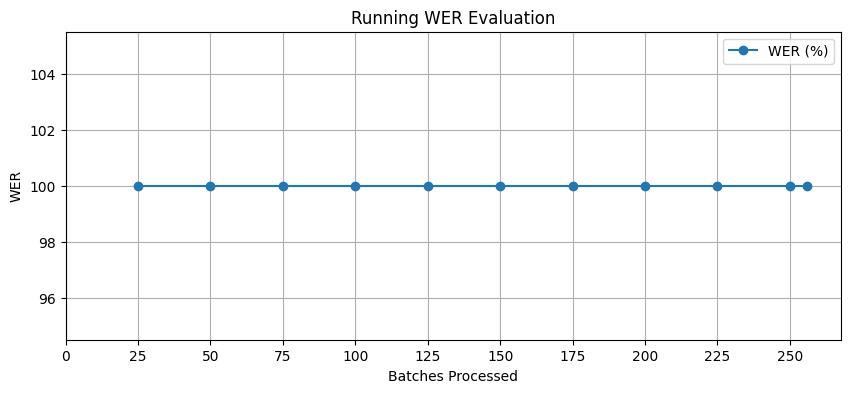

100%|██████████| 256/256 [1:01:00<00:00, 14.30s/it]


100.0

In [92]:
# Evaluate WER after the training
torch.cuda.empty_cache()
evaluation(trainer.model)

In [91]:
#------------------------------Check true vs prediction on few sentences after fine-tuning (using model loaded from local i.e "trained_model")------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["train"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["train"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = trainer.model.generate(input_feature, language='bengali', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


-------7------
True : চলতে পারিনা 
Pred :  is

 
-------8------
True : নিজের স্বজনের জন্য 
Pred :  is

 
-------9------
True : সে যুদ্ধকেই 
Pred :  is

 


In [77]:
#------------------------------Check true vs prediction on few sentences after fine-tuning (using model loaded from local i.e "trained_model")------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["train"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["train"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = loaded_model.generate(input_feature, language='bengali', task='transcribe')

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


-------7------
True : চলতে পারিনা 
Pred : 

 
-------8------
True : নিজের স্বজনের জন্য 
Pred : 

 
-------9------
True : সে যুদ্ধকেই 
Pred : 

 


In [89]:
#------------------------------Check true vs prediction on few sentences after fine-tuning (using model loaded from local i.e "trained_model")------------------
import torch

for idx in range(7,10):
    # Get the tokenized target labels
    target_tokenized = bangla_dataset["train"][idx]["labels"]

    # Decode the true text from tokenized format
    target_text = tokenizer.decode(target_tokenized, skip_special_tokens=True)

    # Convert input features to tensor and add batch dimension
    input_feature = torch.tensor(bangla_dataset["train"][idx]["input_features"]).unsqueeze(0)

    # Ensure correct data type and move to GPU
    input_feature = input_feature.to(dtype=torch.float32, device='cuda')  # Use float16 if needed

    with torch.no_grad():
        op = final_loaded_model.generate(input_feature, language='bengali', task='transcribe').cuda()

    # Decode predicted text
    text_pred = tokenizer.batch_decode(op, skip_special_tokens=True)[0]

    print(f'-------{idx}------')
    print(f'True : {target_text} \nPred : {text_pred}')
    print('\n ')


-------7------
True : চলতে পারিনা 
Pred : 

 
-------8------
True : নিজের স্বজনের জন্য 
Pred : 

 
-------9------
True : সে যুদ্ধকেই 
Pred : 

 
